In [26]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

In [27]:
df = pd.read_csv("data/feature_engineered/train_vars.csv", engine="python", on_bad_lines="skip")
print(df)

           text_id                                          full_text  \
0     0016926B079C  i think that students would benefit from learn...   
1     0022683E9EA5  when a problem is a change you have to let it ...   
2     00299B378633  dear, principal  if u change the school policy...   
3     003885A45F42  the best time in life is when you become yours...   
4     0049B1DF5CCC  small act of kindness can impact in other peop...   
...            ...                                                ...   
3926  FFD29828A873  i believe using cellphones in class for educat...   
3927  FFD9A83B0849  working alone, students do not have to argue w...   
3928  FFDC4011AC9C  "a problem is a chance for you to do your best...   
3929  FFE16D704B16  many people disagree with albert schweitzer's ...   
3930  FFED00D6E0BD  do you think that failure is the main thing fo...   

      cohesion  syntax  vocabulary  phraseology  grammar  conventions  \
0          3.5     3.5         3.0          3.0   

In [28]:
label_cols = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

In [29]:
feature_cols = df.columns.difference(['text_id', 'full_text'] + label_cols).tolist()

In [30]:
df = df.dropna()

## Feature Importance for 'Cohesion'

In [32]:
X = df[feature_cols]
y = df['cohesion']

# Train/Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


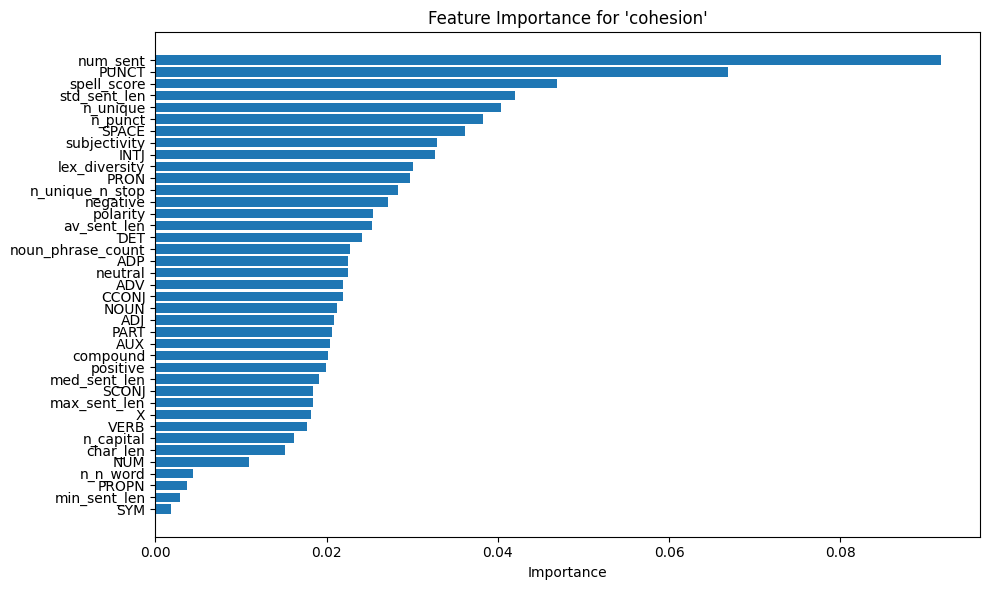

In [33]:
# Model training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Feature Importance
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importances
}).sort_values(by='importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance for 'cohesion'")
plt.tight_layout()
plt.show()

## Feature Importance for all lables

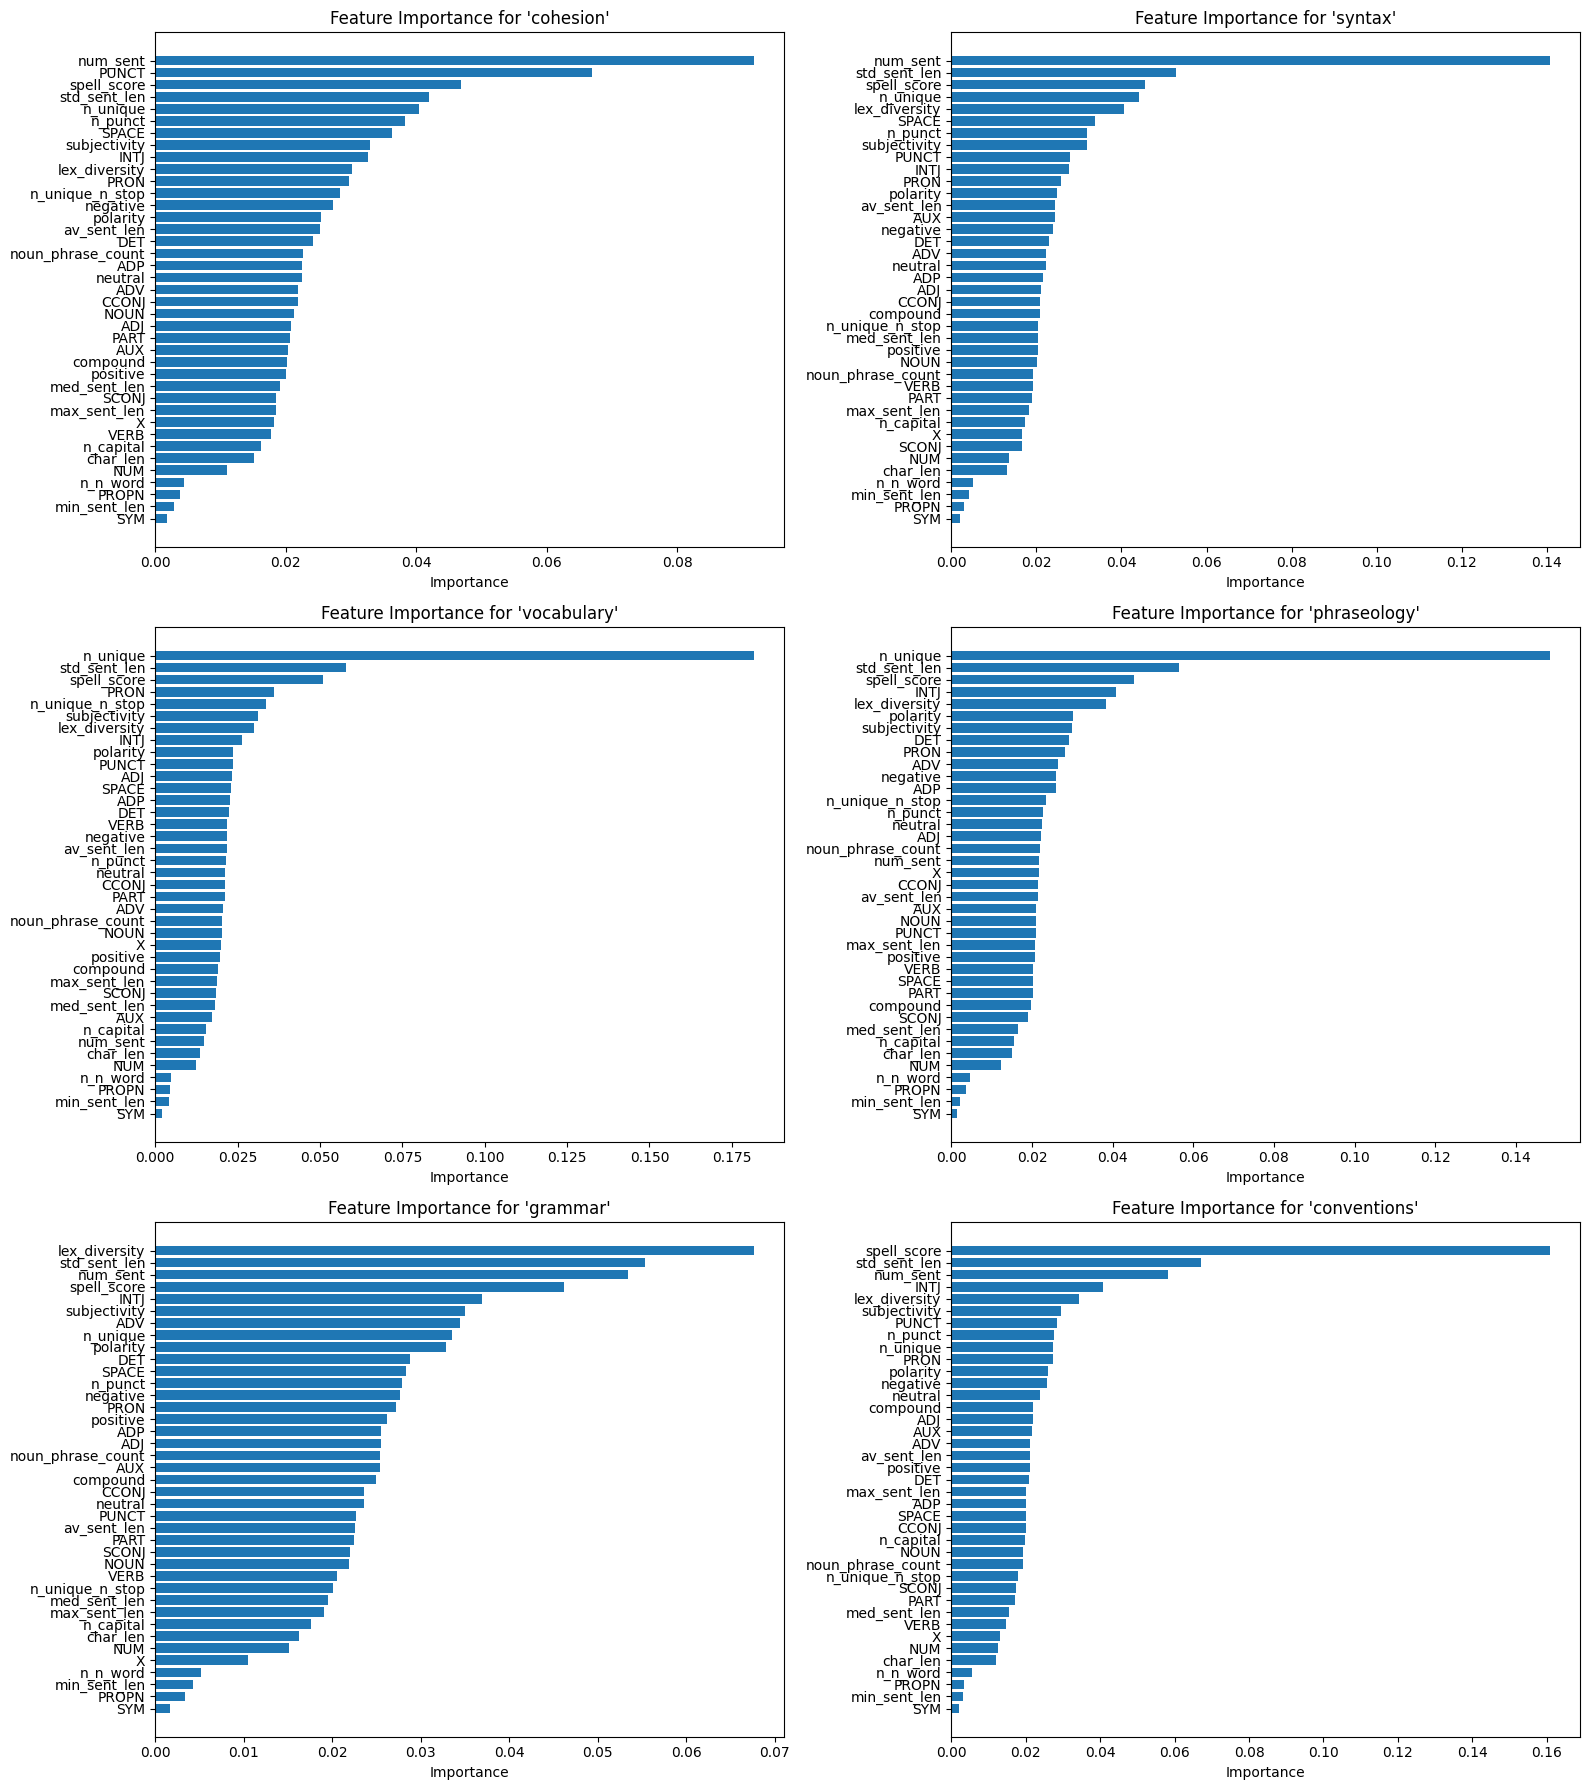

In [34]:
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.flatten()

feature_importance_dict = {}
# iterate over all lables
for i, label in enumerate(label_cols):
    y = df[label]
    
    # Train/Test-Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Model training
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Feature Importance
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    feature_importance_dict[label] = feature_importance_df

    ax = axes[i]
    ax.barh(feature_importance_df['feature'], feature_importance_df['importance'])
    ax.set_title(f"Feature Importance for '{label}'")
    ax.invert_yaxis()
    ax.set_xlabel("Importance")


plt.tight_layout()
plt.show()

In [35]:
combined_importance_df = pd.DataFrame({'feature': feature_cols})
for label, df_imp in feature_importance_dict.items():
    combined_importance_df[label] = df_imp.set_index('feature').reindex(feature_cols).fillna(0).values

# Sum over all lables
combined_importance_df['total_importance'] = combined_importance_df[label_cols].sum(axis=1)

combined_importance_df = combined_importance_df.sort_values(by='total_importance', ascending=False)
print(combined_importance_df.head())

          feature  cohesion    syntax  vocabulary  phraseology   grammar  \
28       n_unique  0.040379  0.044035    0.181712     0.148466  0.033534   
36    spell_score  0.046881  0.045472    0.050906     0.045407  0.046217   
33       num_sent  0.091718  0.140772    0.014777     0.021645  0.053469   
37   std_sent_len  0.041968  0.052877    0.057975     0.056351  0.055315   
21  lex_diversity  0.030111  0.040539    0.030029     0.038237  0.067646   

    conventions  total_importance  
28     0.027374          0.475499  
36     0.160886          0.395769  
33     0.058120          0.380501  
37     0.067219          0.331706  
21     0.034212          0.240775  


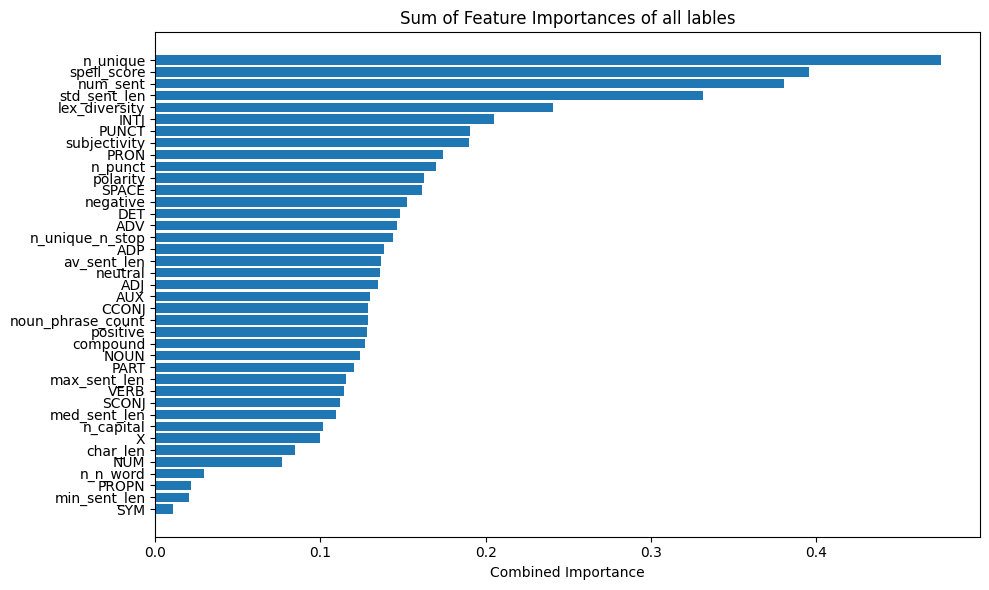

In [36]:
plt.figure(figsize=(10, 6))
plt.barh(combined_importance_df['feature'], combined_importance_df['total_importance'])
plt.gca().invert_yaxis()
plt.xlabel("Combined Importance")
plt.title("Sum of Feature Importances of all lables")
plt.tight_layout()
plt.show()

In [37]:
class MCRMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss(reduction='none')

    def forward(self, preds, targets):
        colwise_mse = self.mse(preds, targets).mean(dim=0)
        colwise_rmse = torch.sqrt(colwise_mse + 1e-8)
        return colwise_rmse.mean()

In [38]:
def evaluate_top_features(combined_importance_df, df, label_cols, n_top_features):
    top_features = combined_importance_df['feature'].iloc[:n_top_features].tolist()
    
    X = df[top_features].values
    y_all = df[label_cols].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_all, test_size=0.2, random_state=42
    )

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_tensor = torch.tensor(y_pred, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    mcrmse_loss = MCRMSELoss()
    loss_value = mcrmse_loss(y_pred_tensor, y_test_tensor)

    print(f"Evaluation with top-{n_top_features} important features: {loss_value.item():.4f}")
    return loss_value.item()



In [39]:
evaluate_top_features(combined_importance_df, df, label_cols, 39)


Evaluation with top-39 important features: 0.5502


0.5502229332923889

In [40]:
evaluate_top_features(combined_importance_df, df, label_cols, 35)

Evaluation with top-35 important features: 0.5513


0.5513396263122559